# 使用CNN在MNIST数据集上实现高准确率(99%准确率)识别

# 卷积神经网络（Convolutional Neural Network, CNN）

<table class="tfo-notebook-buttons" align="left">
  <!-- <td>
    <a target="_blank" href="https://colab.research.google.com/github/tylzh97/UCAS-DeepLearning/blob/main/CNN_MNIST.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />在 Google Colab 中运行</a>
  </td> -->
  <td>
    <a target="_blank" href="https://github.com/tylzh97/UCAS-DeepLearning/blob/main/CNN_MNIST.ipynb"><img src="https://github.com/favicon.ico">在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://github.com/tylzh97/UCAS-DeepLearning/raw/main/CNN_MNIST.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

### 导入相关依赖

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### 使用`tf.datasets`在线加载MNIST数据集


In [2]:
# 在线加载数据集
# 如果在国内运行则需要在终端挂代理
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 将训练集与测试集的图像像素的值标准化至0到1的区间内。
train_images, test_images = train_images / 255.0, test_images / 255.0

# 为了更通用的使用CNN, 图像尺寸通常设置为(<w>, <h>, <1 or 3>)
# MNIST为灰度图像，在此处添加一个维度表示灰度图像
train_images, test_images = train_images[..., tf.newaxis], test_images[..., tf.newaxis]

### 查看数据集样品

将测试集的前 25 张图片和对应的数字打印出来，检查数据集是否被正确加载。


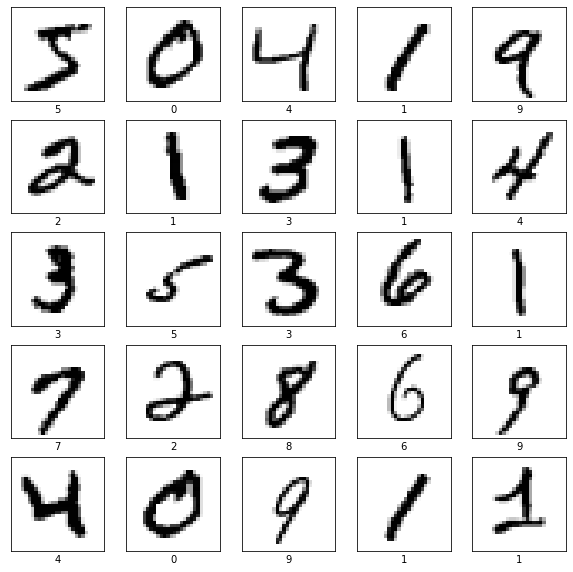

In [3]:
class_names = [str(_) for _ in range(10)]

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i][:, :, 0], cmap=plt.cm.binary)
    # 由于 CIFAR 的标签是 array， 
    # 因此您需要额外的索引（index）。
    plt.xlabel(class_names[train_labels[i]])
plt.show()

### 构造卷积神经网络(CNN)模型

创建一个5层的卷积神经网络，由几个`Conv2D`2维卷积层和`MaxPooling2D`最大池化层组成。

Conv2D的输入是Tensor格式的图像序列, 单张图像的格式为(image_height, image_width, color_channels), 对于图像高度、图像宽度和色彩通道. 

`MNIST`数据集的图像格式为(28, 28), 在数据预处理阶段已经通过`tf.newaxis`将图像转换为(28, 28, 1).


In [4]:
# 创建一个 Sequential 的神经网络模型
model = models.Sequential()
# 添加一个Conv2D层
# 卷积核个数为32; kernel_size为3*3; 使用relu激活函数; 输入图像形状为(28*28*1) 
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# 最大值池化层
model.add(layers.MaxPooling2D((2, 2)))
# 卷积层
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# 最大值池化层
model.add(layers.MaxPooling2D((2, 2)))
# 卷积层
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

此时可以使用summary方法查看模型的结构:

In [5]:
# 查看模型结构
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


`Conv2D`和`MaxPooling2D`的输出都是一个三维的Tensor.

在本模型中, 由于采用了3*3的卷积, 因此第一层输出的shape会减少一个边际点. 

### 增加 Dense(全连接) 层

将卷积后的输出张量传给一个或多个 Dense 层来完成分类。

使用`Flatten`层将3维Tensor展开到1维, 然后使用Dense层进行分类

MNIST数据集有 10 个类，因此您最终的 Dense 层需要 10 个输出及一个 softmax 激活函数。

In [6]:
# 添加一个flatten层, 将3维tensor展开成1维向量
model.add(layers.Flatten())
# 添加一个64个神经元的全连接层, 使用relu作为激活函数
model.add(layers.Dense(64, activation='relu'))
# 添加一个10个神经元的全连接层, 对应10类输出
model.add(layers.Dense(10))

查看完整的 CNN 结构：

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

可以看出，在被传入两个 Dense 层之前，形状为 (3, 3, 64) 的输出被展平成了形状为 (576) 的向量。

### 编译并训练模型

In [8]:
# 编译模型
## 选用adam优化器; 选用交叉熵作为损失函数; 选用accuracy作为评价指标
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 训练模型
history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.1430 - accuracy: 0.9559 - val_loss: 0.0455 - val_accuracy: 0.9872
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0414 - val_accuracy: 0.9875
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0326 - accuracy: 0.9898 - val_loss: 0.0348 - val_accuracy: 0.9892
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0326 - val_accuracy: 0.9900
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0196 - accuracy: 0.9934 - val_loss: 0.0357 - val_accuracy: 0.9893
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0157 - accuracy: 0.9949 - val_loss: 0.0409 - val_accuracy: 0.9872
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0132 - accuracy: 0.9959 - val_loss: 0.0303 - val_accuracy:

### 评估模型

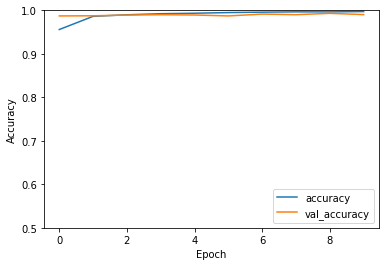

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()


In [10]:
# 显示模型评价指标
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print('该模型测试集 loss为:', test_loss)
print('该模型测试集 ACC 为:', test_acc)

313/313 - 0s - loss: 0.0377 - accuracy: 0.9903
该模型测试集 loss为: 0.037700388580560684
该模型测试集 ACC 为: 0.9902999997138977


我们搭建的简单的 CNN 模型在测试集上可以达到 99% 的准确率。

# 预测图像

为了是模型有良好的线性输出, 通常会在输出层添加一个Softmax层

In [26]:
# 添加一个softmax层使模型具有线性输出
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

该图片的预测值为： 2


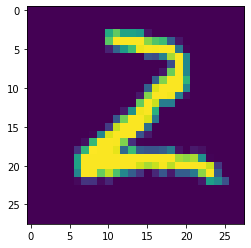

In [31]:
# 输入一个(28*28*1)的图像，显示图像并显示模型的预测结果
def predictSingleImage(img):
    plt.imshow(img[:, :, 0])
    predictions = probability_model.predict(img[tf.newaxis, ..., tf.newaxis])
    ans = np.argmax(predictions[0])
    print("该图片的预测值为：", ans)

predictSingleImage(test_images[996])


# 总结与分析

本实验创建了一个3层Conv2D; 2层MaxPooling2D的CNN网络, 用于在MNIST数据集上的高精度手写数字识别. 经过实验, 最终识别准确率高, 达到了99%, 且训练时间短(Intel i7 2.5GHz 处理器耗时1分钟).